In [1]:
import pandas as pd
#pd.set_option('display.max_columns', 500)
#pd.set_option('display.max_rows', 500)

import numpy as np
 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set()

import pymc3 as pm
print(pm.__version__)
import theano.tensor as tt
import patsy

import scipy.sparse

C:\Miniconda3\envs\ppc\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


3.4.1


# Reaction Times In A Sleep Deprivation Study
The dataset contains the average reaction time per day for subjects in a sleep deprivation study. On day 0 the subjects had their normal amount of sleep. Starting that night they were restricted to 3 hours of sleep per night. The observations represent the average reaction time on a series of tests given each day to each subject. Data from: https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/lme4/sleepstudy.csv

### Data loading

In [2]:
sleep = pd.read_csv('../datasets/sleepstudy.csv', index_col=0)
sleep['Subject'] = pd.Categorical(sleep['Subject'], ordered=False)
sleep.head(15)

,Reaction,Days,Subject
1,249.5600,0,308
2,258.7047,1,308
3,250.8006,2,308
4,321.4398,3,308
5,356.8519,4,308
6,414.6901,5,308
7,382.2038,6,308
8,290.1486,7,308
9,430.5853,8,308
10,466.3535,9,308


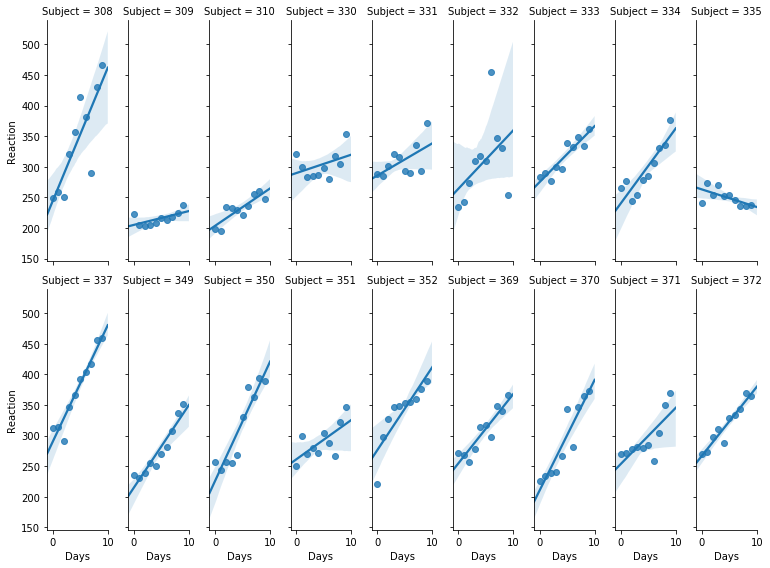

In [3]:
sns.lmplot(x="Days", y="Reaction", col="Subject", data=sleep, col_wrap=9, palette="muted", aspect=0.3, size=4)


## Random effect on the intercepts and slopes
Note: It may be beneficial to center and standardize the data

Design matrix for the fixed effect

In [4]:
X = patsy.dmatrix("1 + Days", data=sleep, return_type='dataframe')
X = np.asarray(X)
X[1:15, :]

array([[1., 1.],
       [1., 2.],
       [1., 3.],
       [1., 4.],
       [1., 5.],
       [1., 6.],
       [1., 7.],
       [1., 8.],
       [1., 9.],
       [1., 0.],
       [1., 1.],
       [1., 2.],
       [1., 3.],
       [1., 4.]])

Design matrix for the random effects. Intercept and slope are modelled separately to have more control on the prior

In [5]:
# Random effect on the intercepts and slopes
Z_intercept = patsy.dmatrix('0 + Subject', data=sleep, return_type='dataframe')
Z_intercept = np.asarray(Z_intercept)

Z_slope = patsy.dmatrix('0 + Subject:Days', data=sleep, return_type='dataframe')
Z_slope = np.asarray(Z_slope)

Z = np.concatenate((Z_intercept, Z_slope), axis=1)

print('Z_intercept has shape ({}, {})'.format(*Z_intercept.shape))
print('Z_slope has shape ({}, {})'.format(*Z_slope.shape))
print('Z has shape ({}, {})'.format(*Z.shape))

Z_intercept has shape (180, 18)
Z_slope has shape (180, 18)
Z has shape (180, 36)


In [6]:
Z_intercept

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [7]:
Z_slope

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [2., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 7.],
       [0., 0., 0., ..., 0., 0., 8.],
       [0., 0., 0., ..., 0., 0., 9.]])

In [8]:
Z

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 7.],
       [0., 0., 0., ..., 0., 0., 8.],
       [0., 0., 0., ..., 0., 0., 9.]])

In [9]:
Y = np.asarray(sleep['Reaction'])

In [10]:
n_random_effects = X.shape[1] #nu = 2
n_subjects = Z_intercept.shape[1] # J = 18

with pm.Model() as model:

    ## Fixed effect
    beta_X_intercept = pm.HalfNormal('beta_X_intercept', sd=10000) # contrain it to positive values
    beta_X_slope = pm.Normal('beta_X_slope', mu=0, sd=100)
    beta_X = tt.stack(beta_X_intercept, beta_X_slope)
    
    estimate_X = pm.math.dot(X, beta_X)
        
    ## Random effect
    # Prior on the standard deviation of the random effects
    sigma_Z = pm.HalfCauchy.dist(beta=2, shape=n_random_effects)
    
    # Build the covariance matrix
    chol_packed = pm.LKJCholeskyCov('chol_packed', n=n_random_effects, eta=1, sd_dist=sigma_Z)
    chol = pm.expand_packed_triangular(n_random_effects, chol_packed)
    
    covariance_matrix = pm.Deterministic('covariance_matrix', tt.dot(chol, chol.T))
    standard_deviations = pm.Deterministic('standard_deviations', tt.sqrt(tt.diag(covariance_matrix)))
       
    # independent component for each subject and each random effect
    gamma_Z_raw = pm.MvNormal('gamma_Z_raw', mu=np.zeros(n_random_effects), chol=chol, shape=(n_subjects, n_random_effects))
    
    # Compute the correlated random variables via the covariance matrix
    gamma_Z = tt.dot(chol, gamma_Z_raw.T)
    
    # Separate the coefficients for intercept and slope
    gamma_Z_intercept = pm.Deterministic('gamma_Z_intercept', gamma_Z[0, :])
    gamma_Z_slope = pm.Deterministic('gamma_Z_slope', gamma_Z[1, :])
    
    estimate_Z = pm.math.dot(Z_intercept, gamma_Z_intercept) + pm.math.dot(Z_slope, gamma_Z_slope) 

    ## likelihood
    mu_estimate = estimate_X + estimate_Z
    sigma_unexplained = pm.HalfNormal('sigma_unexplained', sd=1000) # unexplained variability
    y_likelihood = pm.Normal('y_likelihood', mu=mu_estimate, sd=sigma_unexplained, observed=Y)
    
    trace = pm.sample(draws=3000, chains=4, njobs=4, tune=1500, nuts_kwargs={'target_accept':0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_unexplained_log__, gamma_Z_raw, chol_packed_cholesky_cov_packed__, beta_X_slope, beta_X_intercept_log__]
The number of effective samples is smaller than 10% for some parameters.


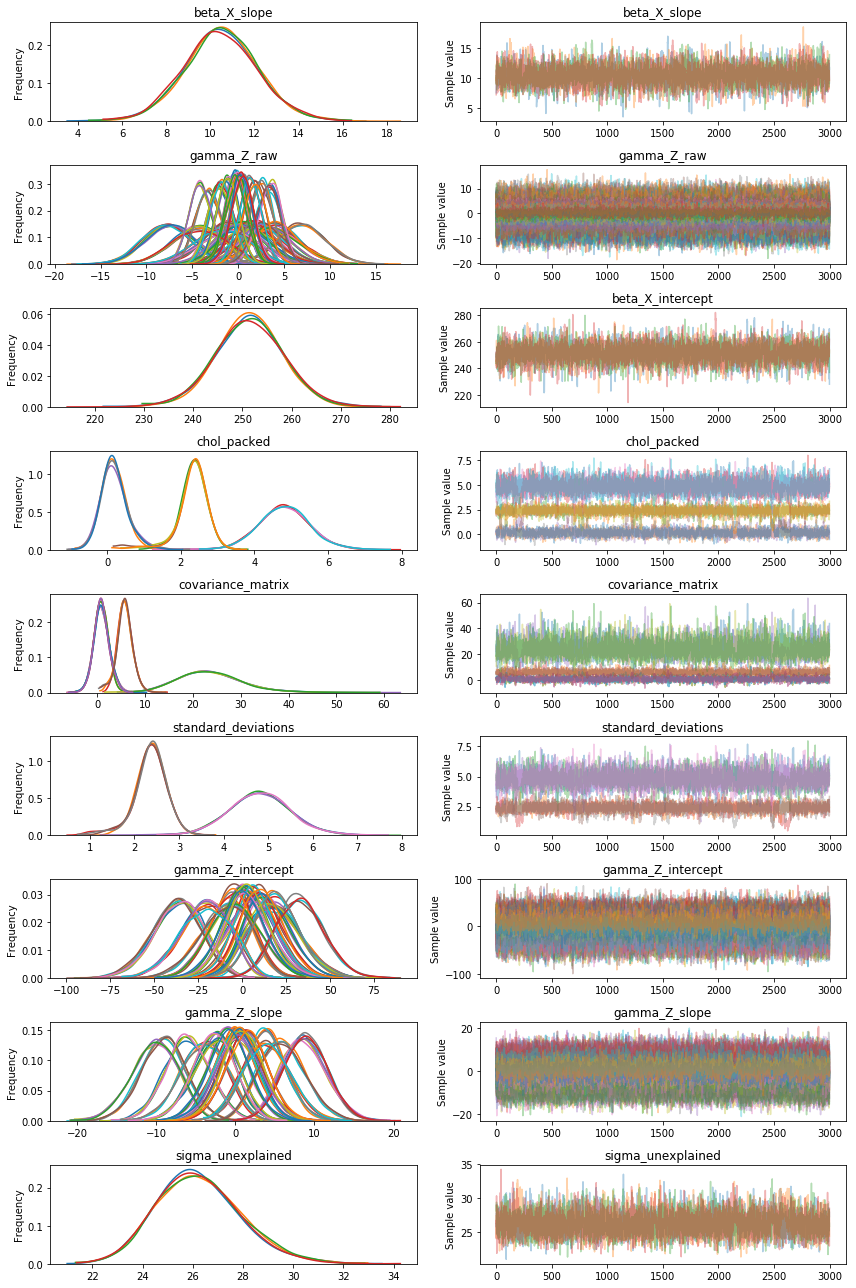

In [11]:
_ = pm.traceplot(trace)

In [12]:
covariance_matrix = np.mean(trace['covariance_matrix'], 0)
covariance_matrix

array([[23.63072313,  0.83583817],
       [ 0.83583817,  5.72838631]])

In [13]:
# check code from https://blogs.sas.com/content/iml/2010/12/10/converting-between-correlation-and-covariance-matrices.html
#/** convert covariance matrix to correlation matrix **/
#/** standard deviations of each variable **/
D = np.sqrt(scipy.sparse.diags(np.diag(covariance_matrix)).todense())
DInv = np.linalg.inv(D)
R = DInv * covariance_matrix * DInv #/** correlation matrix **/
print(R)

# for checking, compute pearson coefficient
print(covariance_matrix[0, 1]/np.prod(np.sqrt(np.diag(covariance_matrix))))

[[1.        0.0718402]
 [0.0718402 1.       ]]
0.07184020200820551


In [14]:
# check code from https://blogs.sas.com/content/iml/2010/12/10/converting-between-correlation-and-covariance-matrices.html
#/** convert covariance matrix to correlation matrix **/
S = np.array([
        [1.0, 1., 8.1],
        [1.0, 16.0, 18.0],
        [8.1,18.0,81.0]
]);
 
#/** standard deviations of each variable **/
D = np.sqrt(scipy.sparse.diags(np.diag(S)).todense())
DInv = np.linalg.inv(D)
R = DInv * S * DInv #/** correlation matrix **/
print(R)

#Should be
#
#[[1.   0.25 0.9 ]
# [0.25 1.   0.5 ]
# [0.9  0.5  1.  ]]
#

[[1.   0.25 0.9 ]
 [0.25 1.   0.5 ]
 [0.9  0.5  1.  ]]


In [15]:
trace_df = pm.trace_to_dataframe(trace)

In [16]:
yvars = [col for col in trace_df.columns if 'gamma_Z_slope' in col and 'raw' not in col]
xvars = [col for col in trace_df.columns if 'gamma_Z_intercept' in col and 'raw' not in col]

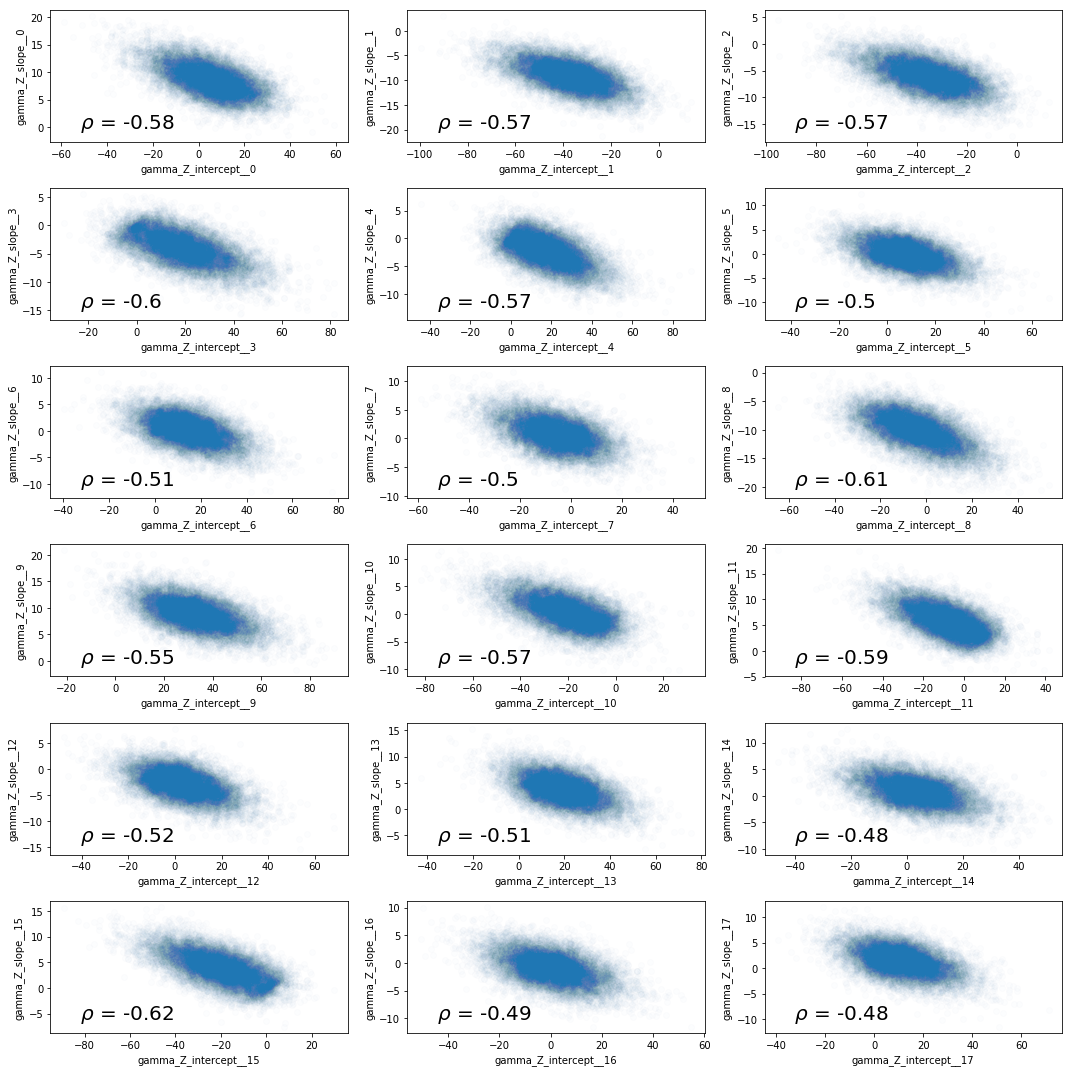

In [17]:
fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(15, 15))
for i, axi in enumerate(ax.ravel()):
    axi.plot(trace_df[xvars[i]], trace_df[yvars[i]], 'o', alpha=0.01)
    axi.set_xlabel(xvars[i])
    axi.set_ylabel(yvars[i])
    axi.text(0.1, 0.1, '$\\rho$ = {}'.format(np.round(np.corrcoef(trace_df[xvars[i]], trace_df[yvars[i]])[0, 1], 2)),
             fontsize=20, transform=axi.transAxes)
    
plt.tight_layout()

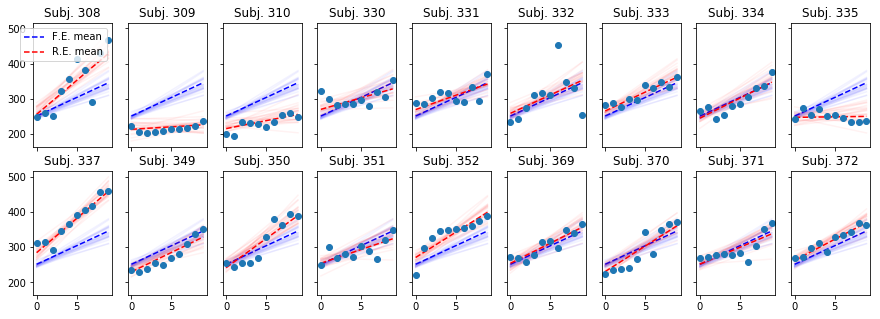

In [18]:
days = np.unique(sleep.Days)
subject_ids = np.unique(sleep.Subject)

fig, ax = plt.subplots(nrows=2, ncols=9, figsize=(15, 5), sharex=True, sharey=True)
ax = ax.ravel()
    
# Main effect  
for i, subject in enumerate(subject_ids):
    for b0, b1 in zip(trace_df['beta_X_intercept'][::500], 
                      trace_df['beta_X_slope'][::500]):
        ax[i].plot(days, b0 + days*b1, '-b', alpha=0.05)
        ax[i].set_title('Subj. {}'.format(subject))

        
for i, subject in enumerate(subject_ids):
    ax[i].plot(days, trace_df['beta_X_intercept'].mean() + days*trace_df['beta_X_slope'].mean(), '--b',
              label='F.E. mean')
    
# Random effect
for i, subject in enumerate(subject_ids):
    for b0, b1 in zip(trace_df['gamma_Z_intercept__{}'.format(i)][::500], 
                      trace_df['gamma_Z_slope__{}'.format(i)][::500]):
        ax[i].plot(days, trace_df['beta_X_intercept'].mean() + b0 + 
                   days * (trace_df['beta_X_slope'].mean() + b1), '-r', alpha=0.05)

for i, subject in enumerate(subject_ids):
    ax[i].plot(days,
               trace_df['beta_X_intercept'].mean() + trace_df['gamma_Z_intercept__{}'.format(i)].mean() + 
               days * (trace_df['beta_X_slope'].mean() + trace_df['gamma_Z_slope__{}'.format(i)].mean()), '--r', 
               label='R.E. mean')    
    

for i, subject in enumerate(subject_ids):
    ax[i].plot(days, sleep.Reaction[sleep.Subject==subject].values, 'o')
    

ax[0].legend()

In [19]:
ppc = pm.sample_ppc(trace, samples=250, model=model)

100%|████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 1072.20it/s]


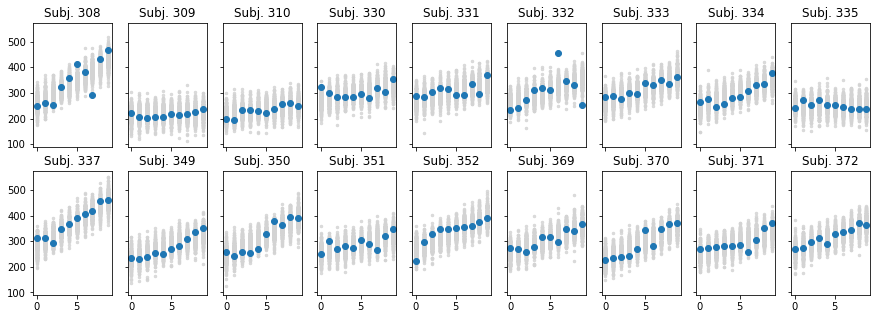

In [20]:
days = np.unique(sleep.Days)
subject_ids = np.unique(sleep.Subject)

fig, ax = plt.subplots(nrows=2, ncols=9, figsize=(15, 5), sharex=True, sharey=True)
ax = ax.ravel()
    
# Main effect  
for i, subject in enumerate(subject_ids):
    ax[i].plot(days, ppc['y_likelihood'].T[sleep.Subject==subject], marker='.', markersize=5, linestyle='none', alpha=0.8, color='lightgray')
    ax[i].plot(days, sleep.Reaction[sleep.Subject==subject].values, 'o')
    ax[i].set_title('Subj. {}'.format(subject))
